# Definitions

CAGR (Compound Annual Growth Rate) = ((EV/BV)^(1/int(n/24) + 1) - 1) x 100

- BV - beginning value (begin of investment)
- EV - ending value (end of investment)
- n - number of hours (years/months/weeks/days)

MAR (Minimum Acceptable Return) = CAGR / MAXdd

- MAXdd = ((BV/MIN(V))^(1/int(n/24) + 1) - 1) x 100
- MAXdd - maximum drawdown for the period 

RAR (Regressed Annual Return) - same as MAR but using linear regression line or MA to find out difference between prices

# Create test dataframe

In [1]:
import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
from datetime import datetime
from os import environ

from data.get_data import GetData
from data.get_data import DataFactory
from config.config import ConfigFactory
from signals.find_signal import FindSignal
from indicators.indicators import IndicatorFactory
from signals.find_signal import SignalFactory

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

plt.style.use('ggplot')

pd.set_option('display.max_rows', 500)

ticker = "BTCUSDT"
debug = False
# Set environment variable
# Set dataframe dict
dfs = {'stat': {'buy': pd.DataFrame(columns=['time', 'ticker', 'timeframe']),
                'sell': pd.DataFrame(columns=['time', 'ticker', 'timeframe'])}}

# Get configs
configs = ConfigFactory.factory(environ).configs
       
# Set list of available exchanges, cryptocurrencies and tickers
exchanges = {'ByBitPerpetual': {'API': GetData(**configs), 'tickers': [ticker]}}

# Get dict of exchange APIs
exchange_apis = dict()
for exchange in exchanges:
    exchange_api = DataFactory.factory(exchange, **configs)
    tickers = exchanges[exchange]['tickers']
    exchange_api.fill_ticker_dict(tickers)
    exchanges[exchange]['API'] = exchange_api

    # Higher timeframe from which we take levels
work_timeframe = configs['Timeframes']['work_timeframe']
    
# For every exchange, ticker and timeframe in base get cryptocurrency data and write it to correspond dataframe
for exchange, exchange_data in exchanges.items():
    exchange_api = exchange_data['API']
    tickers = exchange_data['tickers']
    timeframes = ['4h', '1h']
    for ticker in tickers:
        for timeframe in timeframes:
            print(f'Exchange is {exchange}, ticker is {ticker}, timeframe is {timeframe}')
            if debug:
                df = pd.read_pickle(f'test_{ticker}_{timeframe}.pkl')
                new_data_flag = True
            else:
                # If cryptocurrency dataframe is in dataframe dict - get it, else - create the new one
                if timeframe == '4h':
                    dfh = dfs.get(ticker, dict()).get(timeframe, dict()).get('data', pd.DataFrame())
                    dfh, data_qty = exchange_api.get_data(pd.DataFrame(), ticker, timeframe, datetime.now())
                else:
                    df = dfs.get(ticker, dict()).get(timeframe, dict()).get('data', pd.DataFrame())
                    # Write data to the dataframe
                    df, data_qty = exchange_api.get_data(df, ticker, timeframe, datetime.now())
            # Create indicator list from search signal patterns list, if has new data and
            # data not from higher timeframe, else get only levels
#             if data_qty > 1:
#                 indicators = list()
#                 points = dict()
#                 if timeframe == work_timeframe:
#                     indicator_list = configs['Indicator_list']
#                 else:
#                     indicator_list = ['Pattern'] # ['SUP_RES', 'LinearReg', 'ATR']
#                 for ttype in ['buy']:
#                     for indicator in indicator_list:
#                         ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
#                         if ind_factory:
#                             indicators.append(ind_factory)
#                     # Write indicators to dataframe, update dataframe dict
#                     dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)
        break # !!!

Exchange is ByBitPerpetual, ticker is BTCUSDT, timeframe is 4h
Exchange is ByBitPerpetual, ticker is BTCUSDT, timeframe is 1h


# Find swing pattern

In [37]:
import talib as ta

# df = pd.read_pickle('../optimizer/ticker_dataframes/PHBUSDT_1h.pkl')

ttype = 'sell'
low_bound = 0
high_bound = 1450

indicators = list()
indicator_list = ['Pattern']
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# get Swing pattern
pattern = SignalFactory().factory('Pattern', ttype, configs)

# get mins and maxs
avg_gap = (df['high'] - df['low']).mean()
gmax = df[df['high_max'] > 0].index
gmin = df[df['low_min'] > 0].index

# create has points
min_len = min(len(gmax), len(gmin))
gmax, gmin = gmax[:min_len], gmin[:min_len]
min_max_idxs, min_max_vals = pattern.get_min_max_indexes(df, gmax, gmin)
                    
# plot the result
ohlc = df[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time').iloc[low_bound:high_bound]
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)

# plot has and min/max points
points = pattern.find_signal(df)
idxs = np.where(points > 0)
df.loc[idxs]

# has = pattern.swing(df, min_max_idxs, min_max_vals, avg_gap)
# has_points = df.loc[has > 0, 'close']
# has_points = has_points[(has_points.index >= low_bound) & (has_points.index <= high_bound)]
# has_points = has_points[[has_points.index[i] for i in range(0, len(has_points), 4)]]
# if ttype == 'buy':
#     scatter_max_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
#     scatter_max_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
#     scatter_min_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
#     scatter_min_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
# else:
#     scatter_max_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
#     scatter_max_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
#     scatter_min_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
#     scatter_min_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]

# ax.scatter(scatter_max_idxs - low_bound, scatter_max_vals, s=20, color='green')
# ax.scatter(scatter_min_idxs - low_bound, scatter_min_vals, s=20, color='red')
# ax.scatter(has_points.index - low_bound, has_points.values, s=30, color='blue')

# lr = df['close'].rolling(24).mean()
# ax.plot(lr, color='violet')

,time,open,high,low,close,volume,funding_rate,high_max,low_min
167,2024-09-10 17:00:00,56709.5,57150.0,56485.1,56913.1,7.128522e+08,0.000013,0,1
278,2024-09-15 08:00:00,60095.3,60186.0,60095.3,60119.4,5.288497e+07,0.000075,0,0


# Find ascending/descending triangle

In [39]:
ttype = 'buy'
low_bound = 0
high_bound = 1000

indicators = list()
indicator_list = ['Pattern']
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# get triangle pattern
pattern = SignalFactory().factory('Pattern', ttype, configs)

# get mins and maxs
gmax = df[df['high_max'] > 0].index
gmin = df[df['low_min'] > 0].index    

# create has points
min_len = min(len(gmax), len(gmin))
gmax, gmin = gmax[:min_len], gmin[:min_len]
min_max_idxs, min_max_vals = pattern.get_min_max_indexes(df, gmax, gmin)
                    
# plot the result
ohlc = df[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time').iloc[low_bound:high_bound]
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)

# plot has and min/max points
has = pattern.triangle(df, min_max_idxs, min_max_vals)
has_points = df.loc[has > 0, 'close']
has_points = has_points[(has_points.index >= low_bound) & (has_points.index <= high_bound)]
has_points = has_points[[has_points.index[i] for i in range(0, len(has_points), 4)]]
if ttype == 'buy':
    scatter_max_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_max_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
else:
    scatter_max_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_max_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]

ax.scatter(scatter_max_idxs - low_bound, scatter_max_vals, s=20, color='green')
ax.scatter(scatter_min_idxs - low_bound, scatter_min_vals, s=20, color='red')
ax.scatter(has_points.index - low_bound, has_points.values, s=30, color='blue');

# Find Head & Shoulders pattern

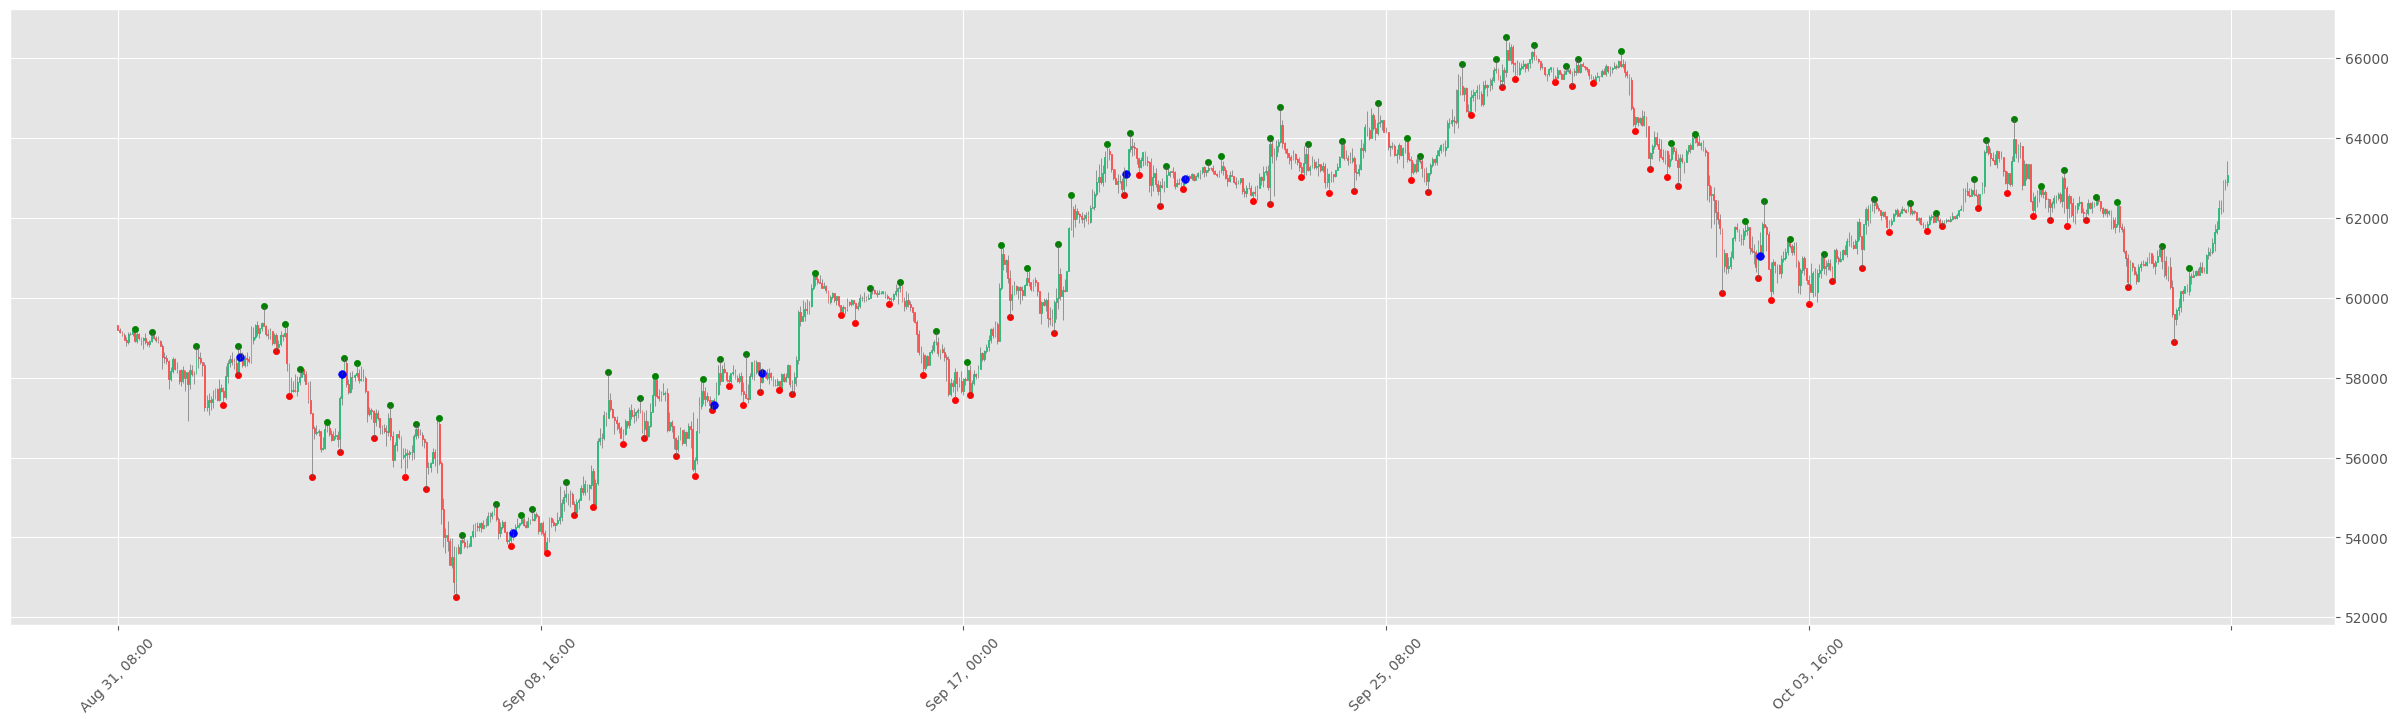

In [5]:
ttype = 'buy'
low_bound = 0
high_bound = 1000

indicators = list()
indicator_list = ['Pattern']
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# get H&S pattern
pattern = SignalFactory().factory('Pattern', ttype, configs)

# get mins and maxs
avg_gap = (df['high'] - df['low']).mean()
gmax = df[df['high_max'] > 0].index
gmin = df[df['low_min'] > 0].index 
    
# create has points
min_len = min(len(gmax), len(gmin))
gmax, gmin = gmax[:min_len], gmin[:min_len]
min_max_idxs, min_max_vals = pattern.get_min_max_indexes(df, gmax, gmin)
                    
# plot the result
ohlc = df[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time').iloc[low_bound:high_bound]
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)

# plot has and min/max points
has = pattern.head_and_shoulders(df, min_max_idxs, min_max_vals)
has_points = df.loc[has > 0, 'close']
has_points = has_points[(has_points.index >= low_bound) & (has_points.index <= high_bound)]
has_points = has_points[[has_points.index[i] for i in range(0, len(has_points), 4)]]
if ttype == 'buy':
    scatter_max_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_max_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
else:
    scatter_max_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_max_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]

ax.scatter(scatter_max_idxs - low_bound, scatter_max_vals, s=20, color='green')
ax.scatter(scatter_min_idxs - low_bound, scatter_min_vals, s=20, color='red')
ax.scatter(has_points.index - low_bound, has_points.values, s=30, color='blue')

# Find HLH/LHL

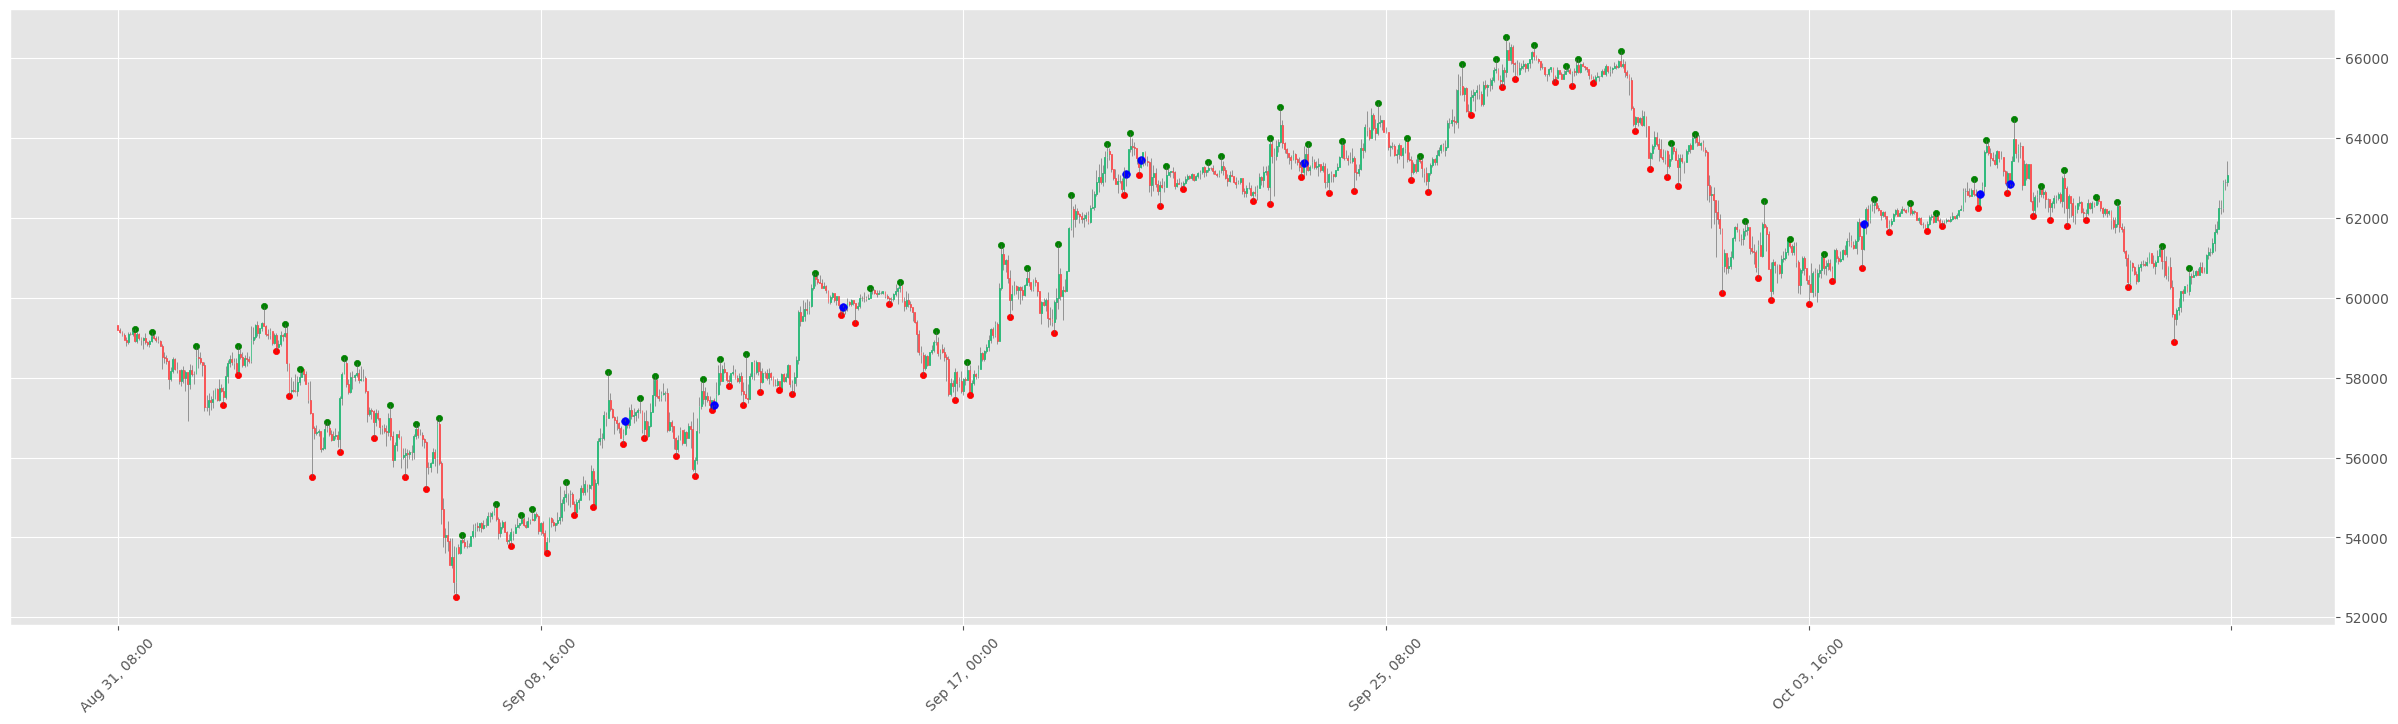

In [6]:
ttype = 'buy'
low_bound = 0
high_bound = 1000

indicators = list()
indicator_list = ['Pattern']
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# get HLH/LHL pattern
pattern = SignalFactory().factory('Pattern', ttype, configs)

def create_pattern_vector(df: pd.DataFrame, res: np.ndarray):
    """ Create vector that shows potential places where we can enter the trade after pattern appearance """
    v = np.zeros(df.shape[0], dtype=int)
    for i in range(1, 2):
        try:
            v[res[res > 0] + i] = 1
        except IndexError:
            break
    return v

def hlh_lhl(df: pd.DataFrame, min_max_idxs: tuple, min_max_vals: tuple) -> np.ndarray:
    """ Find HLH/LHL pattern """
    _, __, ci, di, ei, fi = min_max_idxs
    _, __, civ, div, eiv, fiv = min_max_vals
    if ttype == 'buy':  # LHL
        # find if global maximums and minimums make LHL pattern
        res = np.where((1.005 * civ < eiv) & (1.005 * div < fiv), fi, 0)
    else:  # find HLH
        # find if global maximums and minimums make HLH pattern
        res = np.where((civ > 1.005 * eiv) & (div > 1.005 * fiv), fi, 0)
    v = create_pattern_vector(df, res)
    return v

# get mins and maxs
avg_gap = (df['high'] - df['low']).mean()
gmax = df[df['high_max'] > 0].index
gmin = df[df['low_min'] > 0].index 

# create HLH/LHL points
min_len = min(len(gmax), len(gmin))
gmax, gmin = gmax[:min_len], gmin[:min_len]
min_max_idxs, min_max_vals = pattern.get_min_max_indexes(df, gmax, gmin)
                    
# plot the result
ohlc = df[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time').iloc[low_bound:high_bound]
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)

# plot has and min/max points
has = pattern.hlh_lhl(df, min_max_idxs, min_max_vals)
has_points = df.loc[has > 0, 'close']
has_points = has_points[(has_points.index >= low_bound) & (has_points.index <= high_bound)]
has_points = has_points[[has_points.index[i] for i in range(0, len(has_points), 4)]]
if ttype == 'buy':
    scatter_max_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_max_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
else:
    scatter_max_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_max_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]

ax.scatter(scatter_max_idxs - low_bound, scatter_max_vals, s=20, color='green')
ax.scatter(scatter_min_idxs - low_bound, scatter_min_vals, s=20, color='red')
ax.scatter(has_points.index - low_bound, has_points.values, s=30, color='blue')

# Find DT/DB

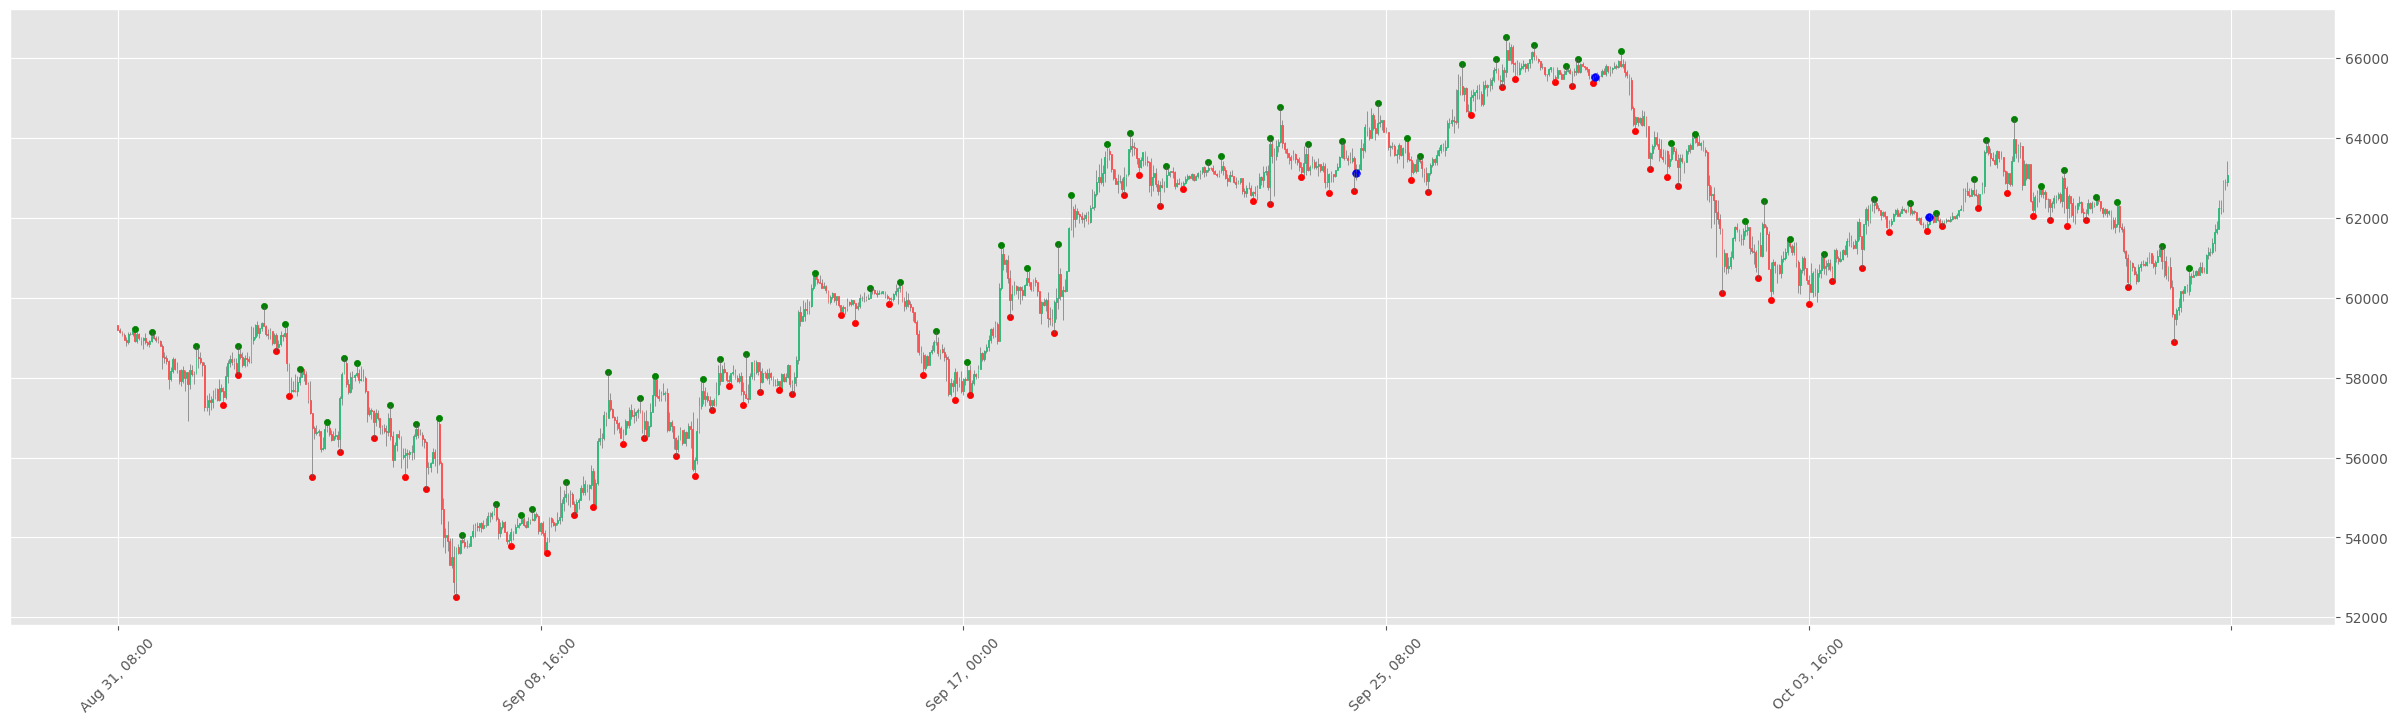

In [7]:
ttype = 'buy'
low_bound = 0
high_bound = 1000

indicators = list()
indicator_list = ['Pattern']
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# get DT/DB pattern
pattern = SignalFactory().factory('Pattern', ttype, configs)

# get mins and maxs
avg_gap = (df['high'] - df['low']).mean()
gmax = df[df['high_max'] > 0].index
gmin = df[df['low_min'] > 0].index 

# create DT/DB points
min_len = min(len(gmax), len(gmin))
gmax, gmin = gmax[:min_len], gmin[:min_len]
min_max_idxs, min_max_vals = pattern.get_min_max_indexes(df, gmax, gmin)
                    
# plot the result
ohlc = df[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time').iloc[low_bound:high_bound]
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)

# plot has and min/max points
has = pattern.dt_db(df, min_max_idxs, min_max_vals)
has_points = df.loc[has > 0, 'close']
has_points = has_points[(has_points.index >= low_bound) & (has_points.index <= high_bound)]
has_points = has_points[[has_points.index[i] for i in range(0, len(has_points), 4)]]
if ttype == 'buy':
    scatter_max_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_max_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
else:
    scatter_max_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_max_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]

ax.scatter(scatter_max_idxs - low_bound, scatter_max_vals, s=20, color='green')
ax.scatter(scatter_min_idxs - low_bound, scatter_min_vals, s=20, color='red')
ax.scatter(has_points.index - low_bound, has_points.values, s=30, color='blue')

# Find two good candles

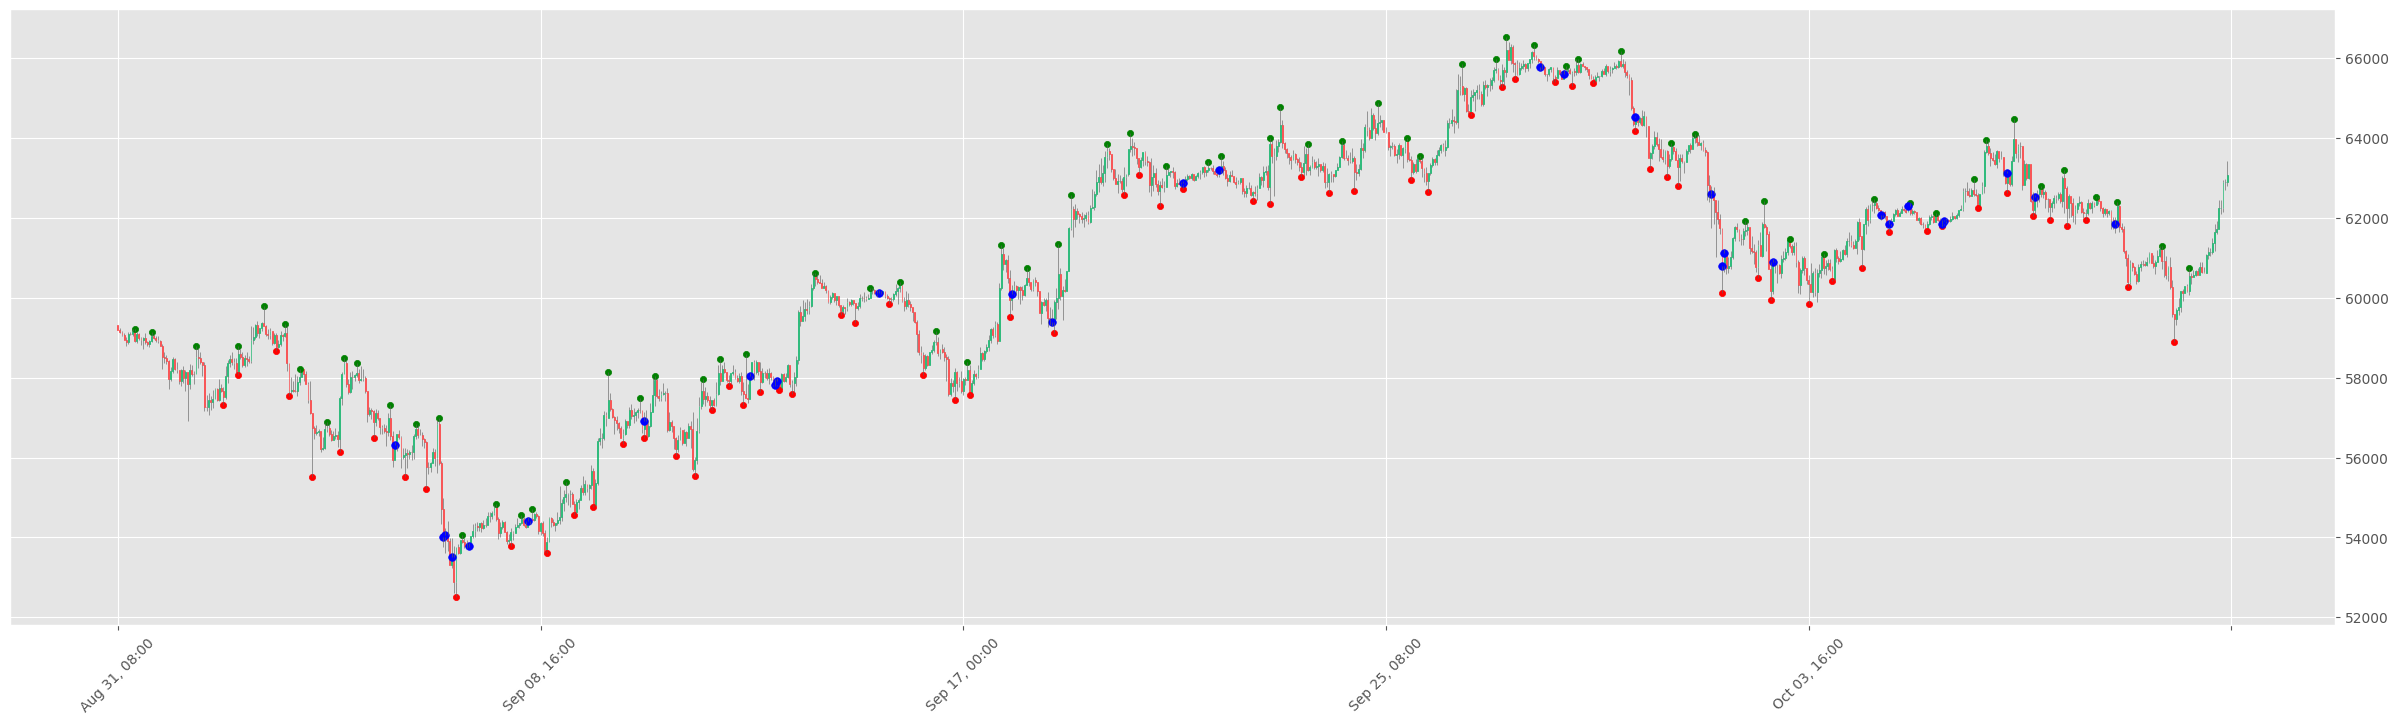

In [8]:
ttype = 'sell'
low_bound = 0
high_bound = 1000

indicators = list()
indicator_list = ['Pattern']
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# get DT/DB pattern
pattern = SignalFactory().factory('Pattern', ttype, configs)

# get mins and maxs
avg_gap = (df['high'] - df['low']).mean()
gmax = df[df['high_max'] > 0].index
gmin = df[df['low_min'] > 0].index 

# create DT/DB points
min_len = min(len(gmax), len(gmin))
gmax, gmin = gmax[:min_len], gmin[:min_len]
min_max_idxs, min_max_vals = pattern.get_min_max_indexes(df, gmax, gmin)
                    
# plot the result
ohlc = df[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time').iloc[low_bound:high_bound]
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)

# plot has and min/max points
tgc = pattern.two_good_candles(df, ttype)
tgc_points = df.loc[tgc > 0, 'close']
tgc_points = tgc_points[(tgc_points.index >= low_bound) & (tgc_points.index <= high_bound)]
if ttype == 'buy':
    scatter_max_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_max_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
else:
    scatter_max_idxs = min_max_idxs[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_max_vals = min_max_vals[-1][(min_max_idxs[-1] >= low_bound) & (min_max_idxs[-1] <= high_bound)]
    scatter_min_idxs = min_max_idxs[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]
    scatter_min_vals = min_max_vals[-2][(min_max_idxs[-2] >= low_bound) & (min_max_idxs[-2] <= high_bound)]

ax.scatter(scatter_max_idxs - low_bound, scatter_max_vals, s=20, color='green')
ax.scatter(scatter_min_idxs - low_bound, scatter_min_vals, s=20, color='red')
ax.scatter(tgc_points.index - low_bound, tgc_points.values, s=30, color='blue')

# Test higher_bound and low_bound methods for RSI indicator

This methods return True if at least two of three last indicator points are higher/lower than high/low bound for this indicator.

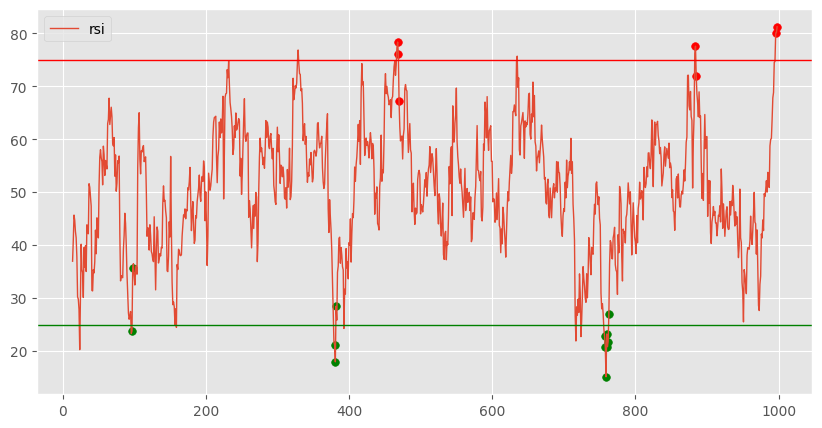

In [9]:
high_bound = 75
low_bound = 25
ttype = 'buy'

# add indicators
indicators = list()
indicator_list = ['RSI', 'STOCH']
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot RSI
ax.plot(df.loc[:, 'rsi'], linewidth=1)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['rsi'])

# plot signal points
scatter_rsi_points = list()
rsi_sig = SignalFactory().factory('RSI', ttype, configs)

rsi_idxs =  rsi_sig.lower_bound(low_bound, df['rsi'], df['rsi'].shift(1), df['rsi'].shift(2))
scatter_buy_rsi_points = df.loc[rsi_idxs>0, 'rsi']
ax.scatter(scatter_buy_rsi_points.index, scatter_buy_rsi_points.values, s=30, color='green')

rsi_idxs =  rsi_sig.higher_bound(high_bound, df['rsi'], df['rsi'].shift(1), df['rsi'].shift(2))
scatter_sell_rsi_points = df.loc[rsi_idxs>0, 'rsi']
ax.scatter(scatter_sell_rsi_points.index, scatter_sell_rsi_points.values, s=30, color='red')
    
plt.show()

# Test up_direction and down_direction methods for STOCH indicator

This methods return True if indicator values increase/decrease.

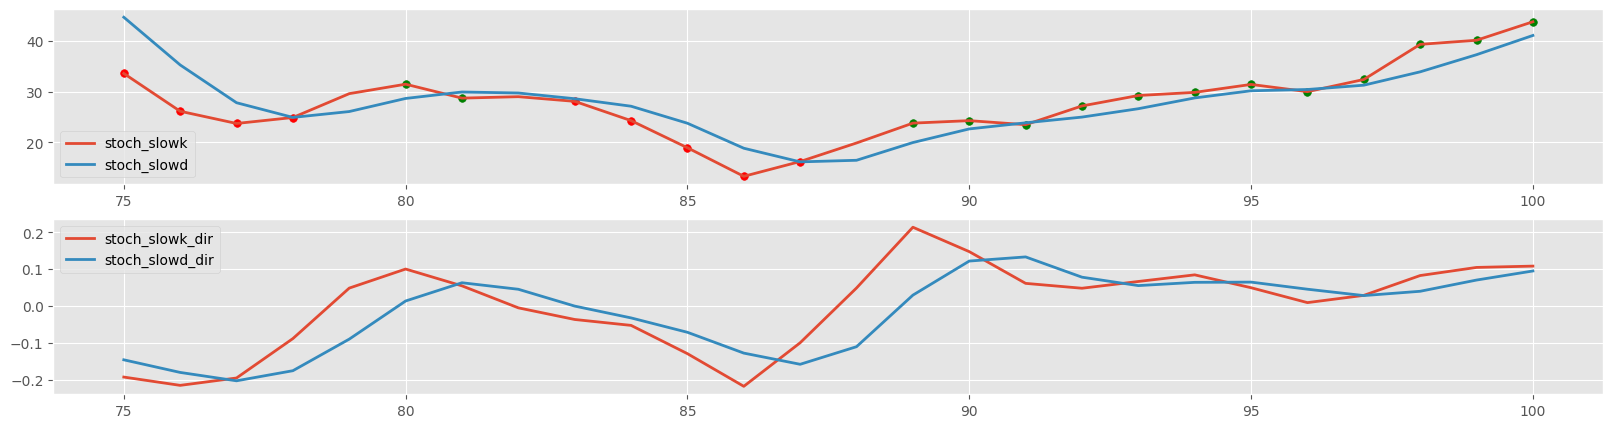

In [10]:
ttype = 'buy'

# add indicators
indicators = list()
indicator_list = ['RSI', 'STOCH']
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# subplots for STOCH
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

# plot STOCH
ax1.plot(df.loc[75:100, 'stoch_slowk'], linewidth=2)
ax1.plot(df.loc[75:100, 'stoch_slowd'], linewidth=2)
ax2.plot(df.loc[75:100, 'stoch_slowk_dir'], linewidth=2)
ax2.plot(df.loc[75:100, 'stoch_slowd_dir'], linewidth=2)
leg = ax1.legend(['stoch_slowk', 'stoch_slowd'])
leg = ax2.legend(['stoch_slowk_dir', 'stoch_slowd_dir'])

# plot signal points
scatter_stoch_points_up = list()
scatter_stoch_points_down = list()

stoch_sig = SignalFactory().factory('STOCH', ttype, configs)

scatter_stoch_points_up = stoch_sig.up_direction(df.loc[75:100, 'stoch_slowk_dir']) & \
                          stoch_sig.up_direction(df.loc[75:100, 'stoch_slowd_dir'])
scatter_stoch_points_down = stoch_sig.down_direction(df.loc[75:100, 'stoch_slowk_dir']) & \
                            stoch_sig.down_direction(df.loc[75:100, 'stoch_slowd_dir'])

ax1.scatter(np.where(scatter_stoch_points_up)[0] + 75, df.loc[np.where(scatter_stoch_points_up)[0] + 75, 'stoch_slowk'], 
            s=30, color='green')
ax1.scatter(np.where(scatter_stoch_points_down)[0] + 75, df.loc[np.where(scatter_stoch_points_down)[0] + 75, 'stoch_slowk'], 
            s=30, color='red')
    
plt.show()

# Test crossed_lines method for STOCH indicator

This methods return True if two lines of indicator has crossed (for previous or pre-previous values).

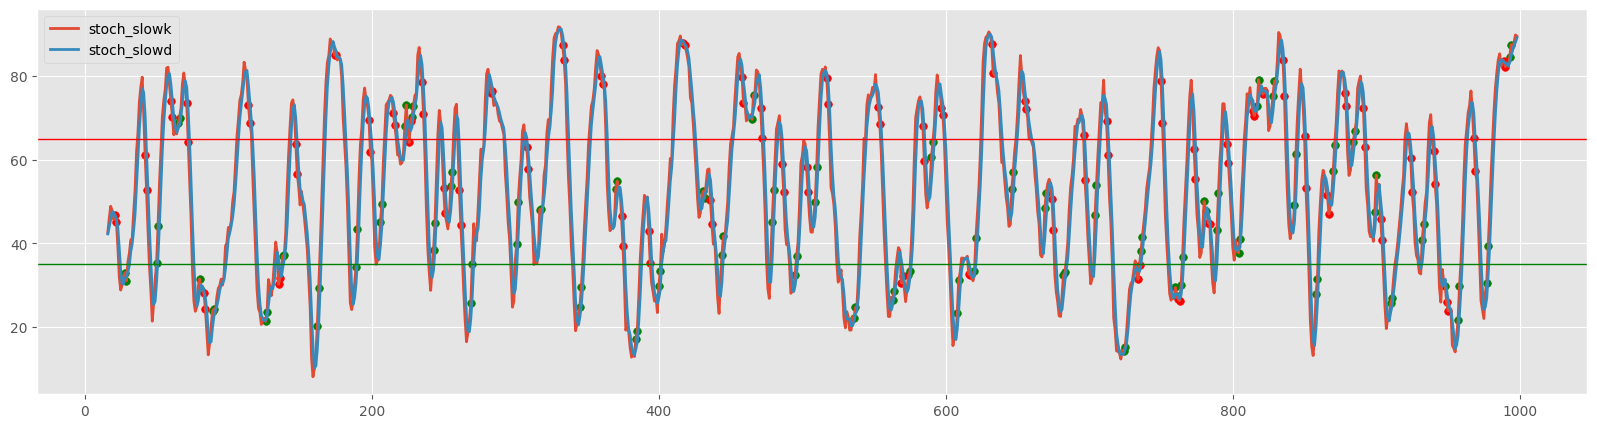

In [11]:
# subplots for RSI
ttype = 'sell'
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

# add indicators
indicators = list()
indicator_list = ['RSI', 'STOCH']
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# plot STOCH
low_bound = 35
high_bound = 65
low_index = 0
high_index = 1000
ax.plot(df.loc[low_index:high_index, 'stoch_slowk'], linewidth=2)
ax.plot(df.loc[low_index:high_index, 'stoch_slowd'], linewidth=2)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
stoch_sig = SignalFactory().factory('STOCH', ttype, configs)
scatter_stoch_points_up = stoch_sig.crossed_lines(False, df.loc[low_index:high_index, 'stoch_diff'], 
                                                  df.loc[low_index:high_index, 'stoch_diff'].shift(1), 
                                                  df.loc[low_index:high_index, 'stoch_diff'].shift(2)) 
scatter_stoch_points_down = stoch_sig.crossed_lines(True, df.loc[low_index:high_index, 'stoch_diff'], 
                                                    df.loc[low_index:high_index, 'stoch_diff'].shift(1), 
                                                    df.loc[low_index:high_index, 'stoch_diff'].shift(2)) 

ax.scatter(np.where(scatter_stoch_points_up)[0] + low_index, df.loc[np.where(scatter_stoch_points_up)[0] + low_index, 
                                                              'stoch_slowk'], s=30, color='green')
ax.scatter(np.where(scatter_stoch_points_down)[0] + low_index, df.loc[np.where(scatter_stoch_points_down)[0] + low_index, 
                                                                'stoch_slowk'], s=30, color='red')
    
plt.show()

# Test find_stoch_signal method for STOCH indicator

This methods return True if STOCH indicator is in overbuy/oversell zone, slowk and slowd lines has crossed and both changed their direction.

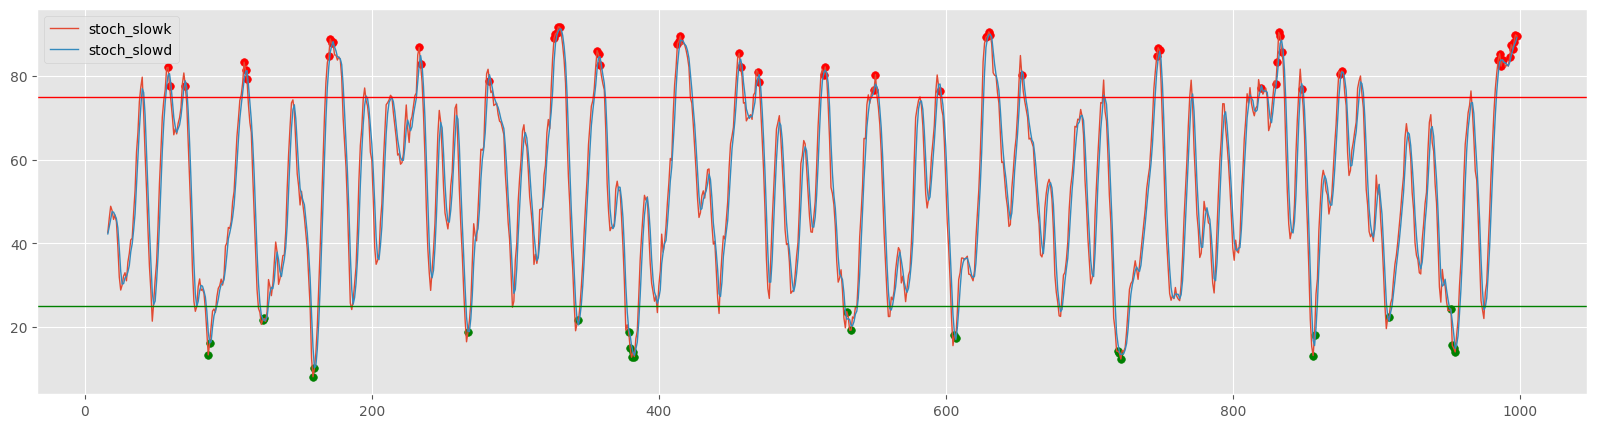

In [12]:
# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

# add indicators
indicators = list()
indicator_list = ['RSI', 'STOCH']
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# plot STOCH
ttype = 'buy'
low_bound = 25
high_bound = 75
low_index = 0
high_index = 1000
ax.plot(df.loc[low_index:high_index, 'stoch_slowk'], linewidth=1)
ax.plot(df.loc[low_index:high_index, 'stoch_slowd'], linewidth=1)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
scatter_stoch_points_buy = list()
scatter_stoch_points_sell = list()
stoch_sig_buy = SignalFactory().factory('STOCH', 'buy', configs)
stoch_sig_sell = SignalFactory().factory('STOCH', 'sell', configs)

fs_buy = stoch_sig_buy.find_signal(df)
fs_sell = stoch_sig_sell.find_signal(df)

for index in range(len(fs_buy)):
    if low_index < index < high_index:
            if fs_buy[index] == 1:
                scatter_stoch_points_buy.append((index, df.loc[index, 'stoch_slowk']))
            if fs_sell[index] == 1:
                scatter_stoch_points_sell.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points_buy:
    ax.scatter(point[0], point[1], s=30, color='green')
    
for point in scatter_stoch_points_sell:
    ax.scatter(point[0], point[1], s=30, color='red')
    
plt.show()

# Test crossed_lines method for MACD indicator

This methods return True if macd and macdsignal lines has crossed and both changed their direction.

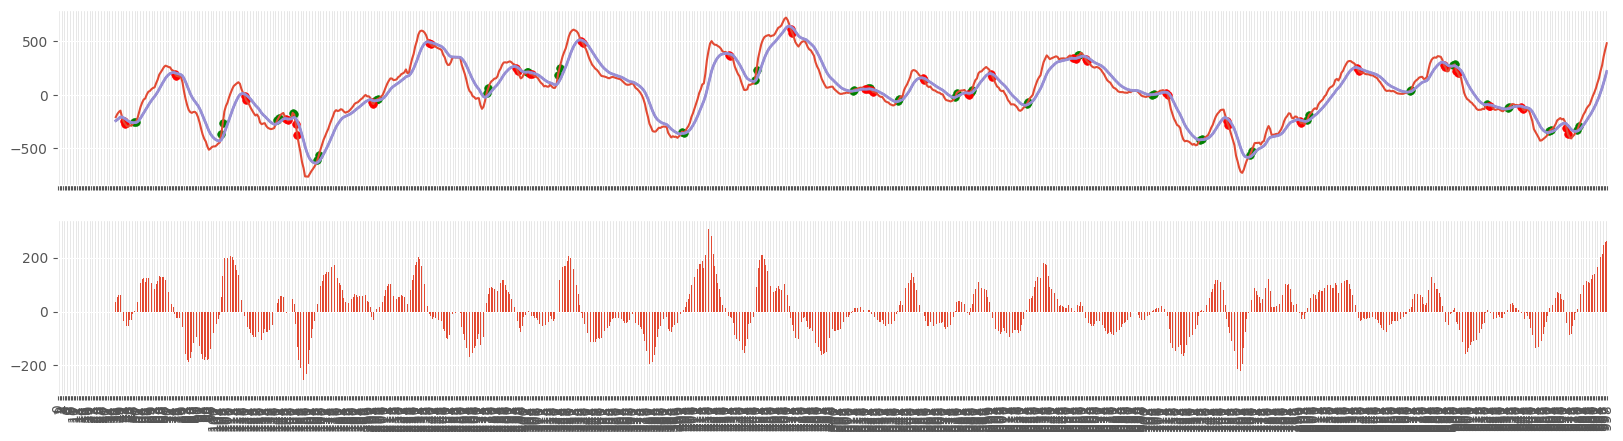

In [13]:
# subplots for MACD
ttype = 'sell'
low_index = 0
high_index = 1000
fig, ax = plt.subplots(2, 1, figsize=(20, 5), sharex=True)

# add indicators
indicators = list()
indicator_list = ['MACD']
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# plot MACD
df.loc[low_index:high_index, 'macd'].plot(ax=ax[0])
df.loc[low_index:high_index, 'macdsignal'].plot(ax=ax[0])
ax[0].plot(df.loc[low_index:high_index, 'macdsignal'], linewidth=2)
ax[0].set_xticks(np.arange(low_index, high_index+1, 20))
ax[0].set_xticklabels(np.arange(low_index, high_index+20, 20))

df.loc[low_index:high_index, 'macdhist'].plot.bar(ax=ax[1])
ax[1].set_xticks(ax[0].get_xticks()-low_index)

# plot signal points
macd_sig = SignalFactory().factory('MACD', ttype, configs)
scatter_stoch_points_up = macd_sig.crossed_lines(False, df.loc[low_index:high_index, 'macdhist'], 
                                                  df.loc[low_index:high_index, 'macdhist'].shift(1), 
                                                  df.loc[low_index:high_index, 'macdhist'].shift(2)) 
scatter_stoch_points_down = macd_sig.crossed_lines(True, df.loc[low_index:high_index, 'macdhist'], 
                                                    df.loc[low_index:high_index, 'macdhist'].shift(1), 
                                                    df.loc[low_index:high_index, 'macdhist'].shift(2)) 

ax[0].scatter(np.where(scatter_stoch_points_up)[0] + low_index, 
              df.loc[np.where(scatter_stoch_points_up)[0] + low_index, 'macd'], s=30, color='green')
ax[0].scatter(np.where(scatter_stoch_points_down)[0] + low_index, 
              df.loc[np.where(scatter_stoch_points_down)[0] + low_index, 'macd'], s=30, color='red')
    
plt.show()

# Test find_signal method for MACD indicator

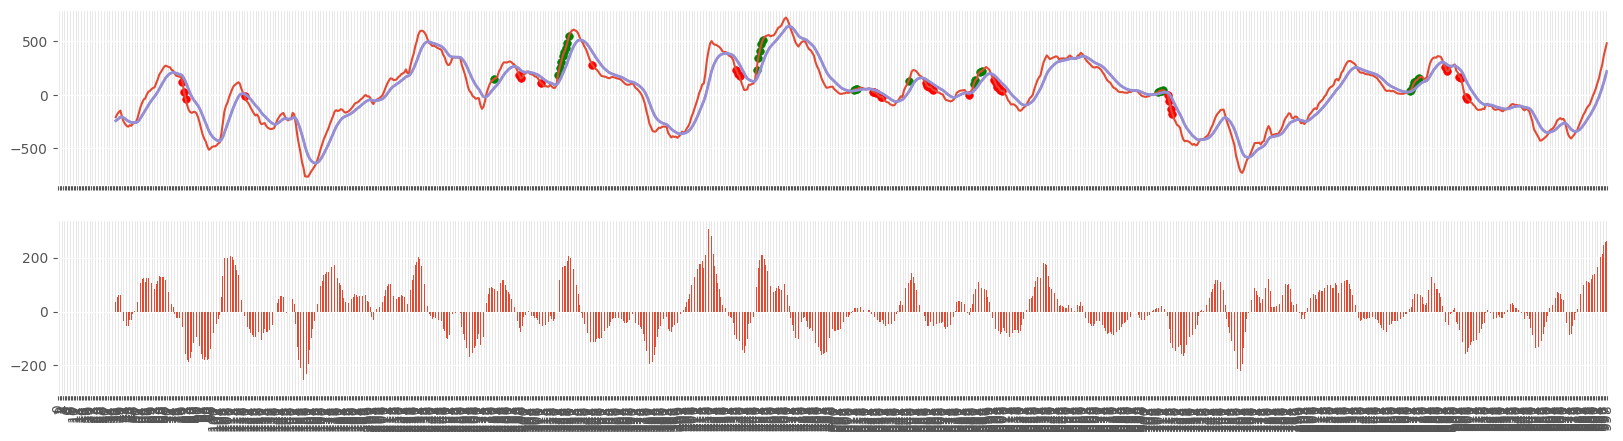

In [14]:
# subplots for MACD
ttype = 'sell'
low_index = 0
high_index = 1000
fig, ax = plt.subplots(2, 1, figsize=(20, 5), sharex=True)

# add indicators
indicators = list()
indicator_list = ['MACD']
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# add trade points (need for signals from higher timeframe)
trade_points, tmp = pd.DataFrame(), pd.DataFrame()
trade_points['time'] = df['time']
# merge higher dataframe timestamps and working dataframe timestamps in one dataframe
tmp['time'] = dfh['time']
tmp['time_higher'] = tmp['time']
# merge work timeframe with higher timeframe, so we can work with indicator values from higher timeframe
trade_points = pd.merge(trade_points[['time']], tmp[['time', 'time_higher']], how='left')
trade_points['time_higher'] = trade_points['time_higher'].fillna(method='ffill')
trade_points['time_higher'] = trade_points['time_higher'].fillna(trade_points['time_higher'].min() - pd.to_timedelta(4, 'h'))

# plot MACD
df.loc[low_index:high_index, 'macd'].plot(ax=ax[0])
df.loc[low_index:high_index, 'macdsignal'].plot(ax=ax[0])
ax[0].plot(df.loc[low_index:high_index, 'macdsignal'], linewidth=2)
ax[0].set_xticks(np.arange(low_index, high_index+1, 20))
ax[0].set_xticklabels(np.arange(low_index, high_index+20, 20))

df.loc[low_index:high_index, 'macdhist'].plot.bar(ax=ax[1])
ax[1].set_xticks(ax[0].get_xticks()-low_index)

# plot signal points
macd_sig_buy = SignalFactory().factory('MACD', 'buy', configs)
macd_sig_sell = SignalFactory().factory('MACD', 'sell', configs)
scatter_stoch_points_buy = macd_sig_buy.find_signal(df.loc[low_index:high_index], 4) 
scatter_stoch_points_sell = macd_sig_sell.find_signal(df.loc[low_index:high_index], 4) 

ax[0].scatter(np.where(scatter_stoch_points_buy)[0] + low_index, 
              df.loc[np.where(scatter_stoch_points_buy)[0] + low_index, 'macd'], s=30, color='green')
ax[0].scatter(np.where(scatter_stoch_points_sell)[0] + low_index, 
              df.loc[np.where(scatter_stoch_points_sell)[0] + low_index, 'macd'], s=30, color='red')
    
plt.show()

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 1h, buy, pattern: (STOCH, RSI))

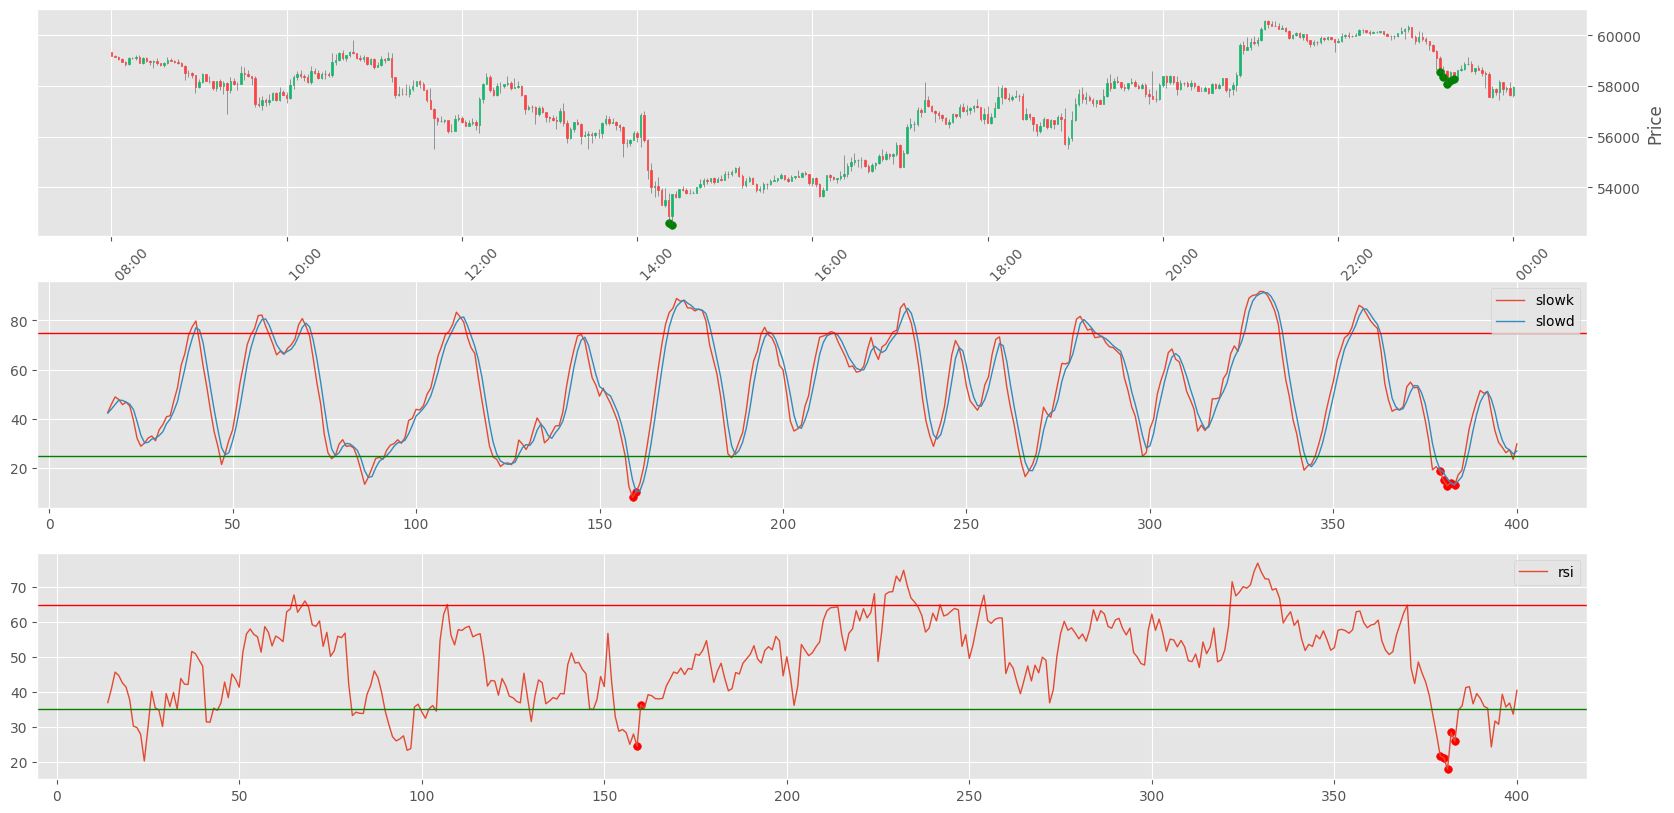

In [15]:
import mplfinance as mpf

ttype = 'buy'
low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# add indicators
indicators = list()
indicator_list = ['STOCH', 'RSI']
configs['Indicator_list'] = indicator_list
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# find signal points
fs = FindSignal(ttype, configs)
fs.patterns = [['STOCH', 'RSI']]
fs.indicator_list = indicator_list
# df = dfs[ticker]['1h']['data'][ttype]
dfs[ticker]['4h'] = dict()
dfs[ticker]['4h']['data'] = dict()
dfs[ticker]['4h']['data'][ttype] = dict()
dfs[ticker]['4h']['data'][ttype] = dfh
data_qty = 1000
data_qty_higher = 1000
points = fs.find_signal(dfs, ticker, '1h', data_qty, data_qty_higher)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'], linewidth=1)
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'], linewidth=1)
# show boundaries
ax2.axhline(y=25, color='g', linestyle='-', linewidth=1)
ax2.axhline(y=75, color='r', linestyle='-', linewidth=1)
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'], linewidth=1)
# show boundaries
ax3.axhline(y=35, color='g', linestyle='-', linewidth=1)
ax3.axhline(y=65, color='r', linestyle='-', linewidth=1)
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[3] == 'buy':
        scatter_candle_points_buy.append((point[2], df.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], df.loc[point[2], 'high']))
    scatter_stoch_points.append((point[2], df.loc[point[2], 'stoch_slowk']))
    scatter_rsi_points.append((point[2], df.loc[point[2], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0]-low_bound, point[1], s=30, color='red')

# plot levels
# for level in levels:
#     if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
#         ax1.axhline(y=level[0], color='r', linestyle='-', linewidth=0.75)
        
plt.show()

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 5m, sell, pattern: (STOCH, RSI))

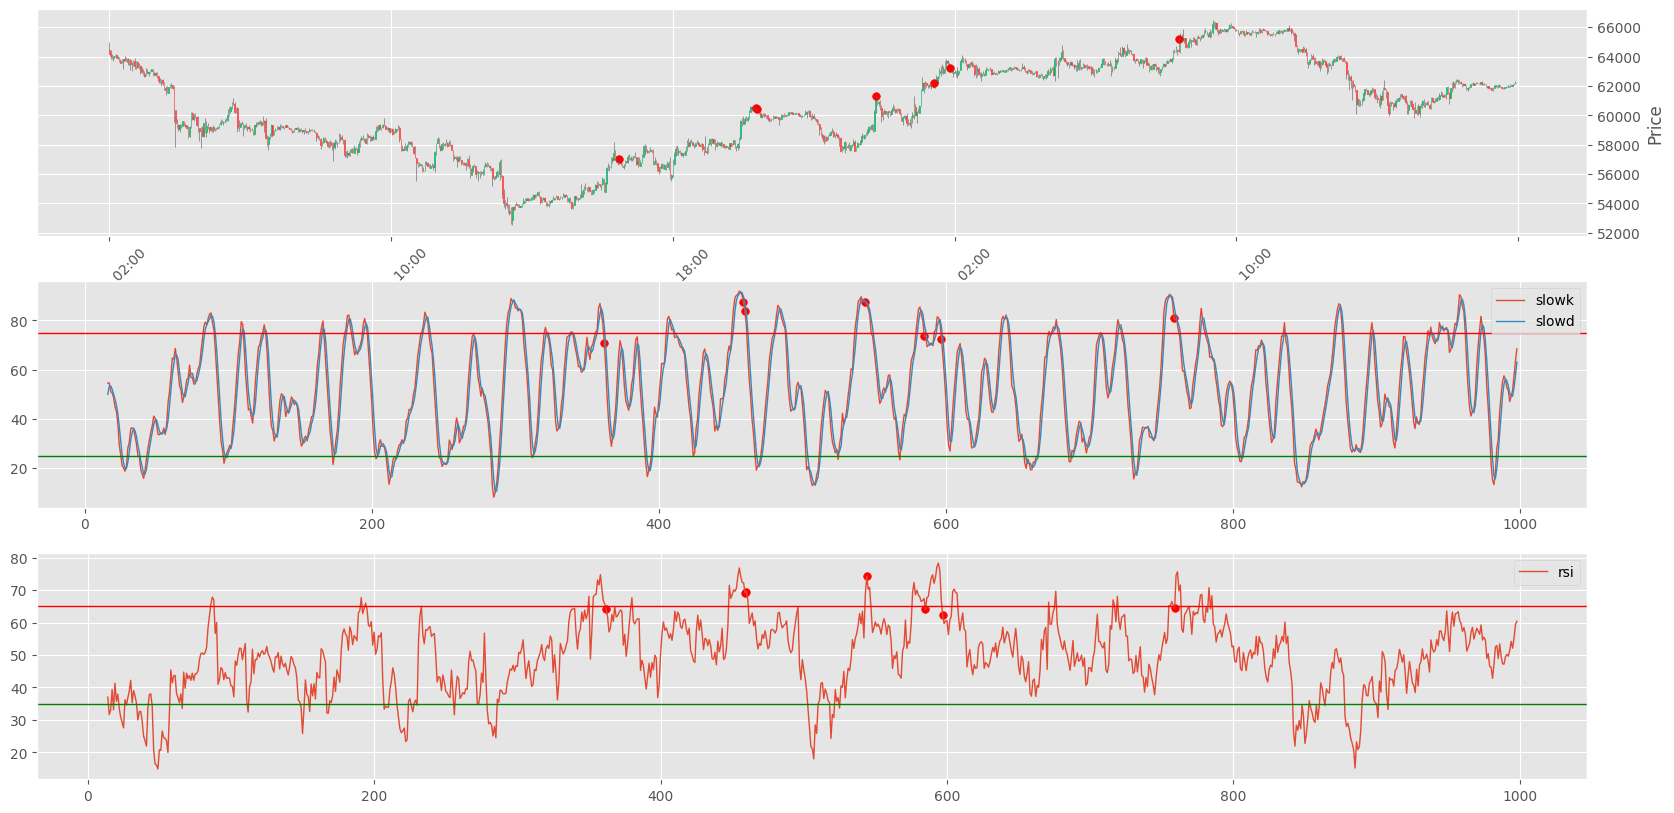

In [34]:
import mplfinance as mpf

ttype = 'sell'
low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# add indicators
indicators = list()
indicator_list = ['STOCH', 'RSI']
configs['Indicator_list'] = indicator_list
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)

# find signal points
fs = FindSignal(ttype, configs)
fs.patterns = [['STOCH', 'RSI']]
fs.indicator_list = indicator_list
# df = dfs[ticker]['1h']['data'][ttype]
dfs[ticker]['4h'] = dict()
dfs[ticker]['4h']['data'] = dict()
dfs[ticker]['4h']['data'][ttype] = dict()
dfs[ticker]['4h']['data'][ttype] = dfh
data_qty = 1000
data_qty_higher = 1000
points = fs.find_signal(dfs, ticker, '1h', data_qty, data_qty_higher)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'], linewidth=1)
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'], linewidth=1)
# show boundaries
ax2.axhline(y=25, color='g', linestyle='-', linewidth=1)
ax2.axhline(y=75, color='r', linestyle='-', linewidth=1)
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'], linewidth=1)
# show boundaries
ax3.axhline(y=35, color='g', linestyle='-', linewidth=1)
ax3.axhline(y=65, color='r', linestyle='-', linewidth=1)
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[3] == 'buy':
        scatter_candle_points_buy.append((point[2], df.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], df.loc[point[2], 'high']))
    scatter_stoch_points.append((point[2], df.loc[point[2], 'stoch_slowk']))
    scatter_rsi_points.append((point[2], df.loc[point[2], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0]-low_bound, point[1], s=30, color='red')

# plot levels
# for level in levels:
#     if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
#         ax1.axhline(y=level[0], color='r', linestyle='-', linewidth=0.75)
        
plt.show()

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 1h, buy, pattern: (Pattern, Trend))

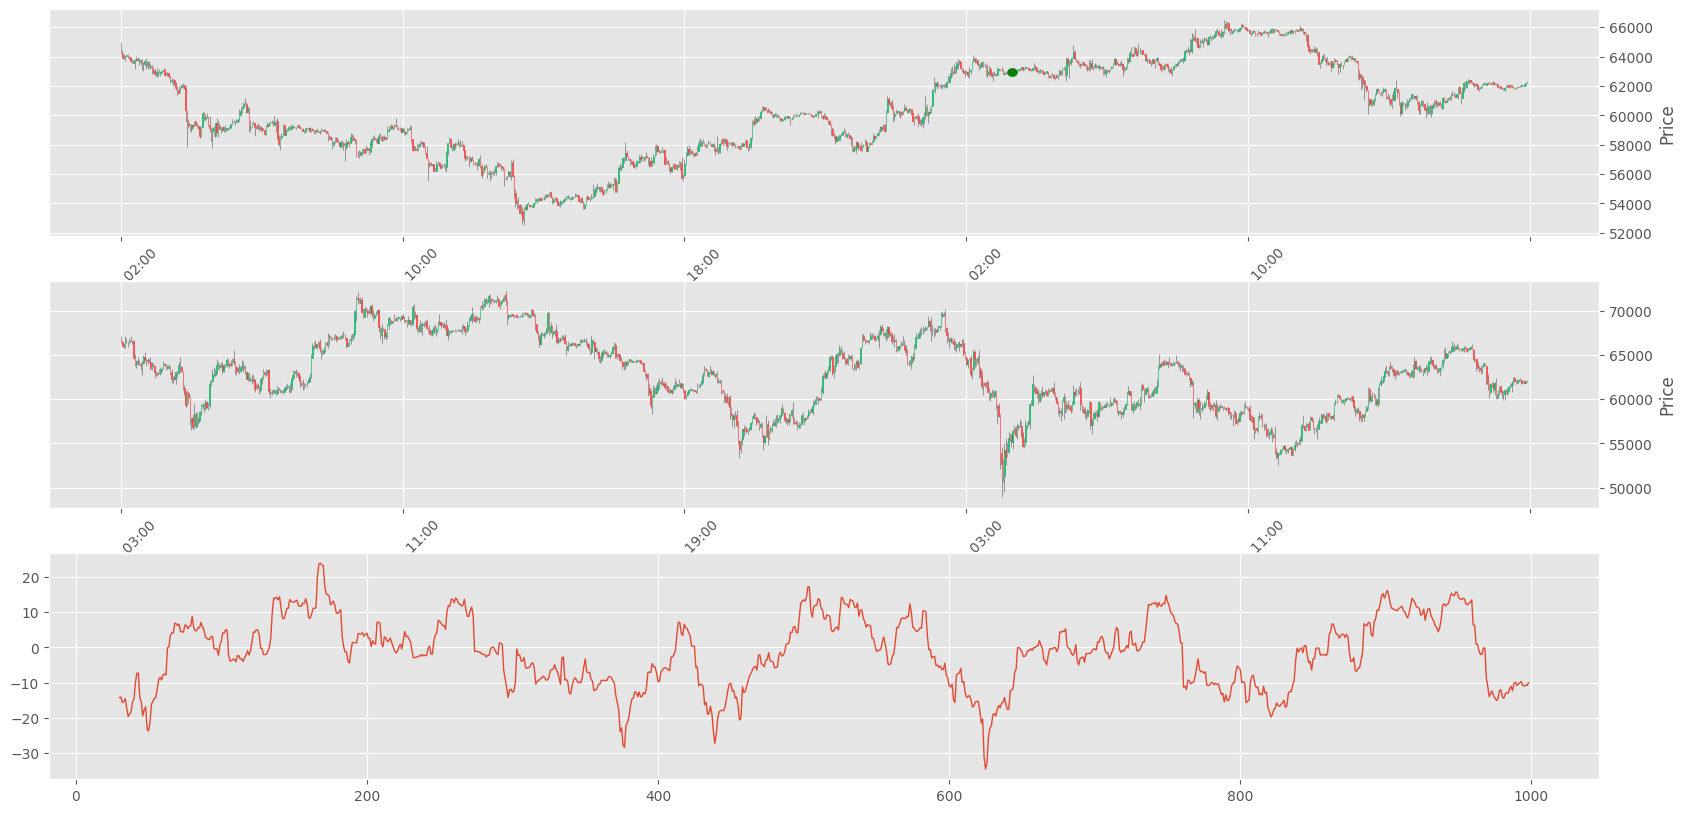

In [35]:
import mplfinance as mpf

ttype = 'buy'
low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# add indicators
indicators = list()
indicator_list = ['Pattern', 'Trend']
configs['Indicator_list'] = indicator_list
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)
        dfs = exchange_api.add_indicator_data(dfs, dfh, ttype, indicators, ticker, '4h', data_qty)

# find signal points
fs = FindSignal(ttype, configs)
fs.patterns = [['Pattern', 'Trend']]
fs.indicator_list = indicator_list
# df = dfs[ticker]['1h']['data'][ttype]
dfs[ticker]['4h'] = dict()
dfs[ticker]['4h']['data'] = dict()
dfs[ticker]['4h']['data'][ttype] = dict()
dfs[ticker]['4h']['data'][ttype] = dfh
data_qty = 1000
data_qty_higher = 1000
points = fs.find_signal(dfs, ticker, '1h', data_qty, data_qty_higher)

# subplots for Pattern and Trend
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

ohlch = dfh.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlch = ohlch.set_index('time')
mpf.plot(ohlch, type='candle', ax=ax2, warn_too_much_data=10000, style='yahoo')

lr_angle = dfh['linear_reg_angle']
ax3.plot(lr_angle, linewidth=1)

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()

for point in points:
    if point[3] == 'buy':
        scatter_candle_points_buy.append((point[2], df.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], df.loc[point[2], 'high']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
plt.show()

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 1h, sell, pattern: (Pattern, Trend))

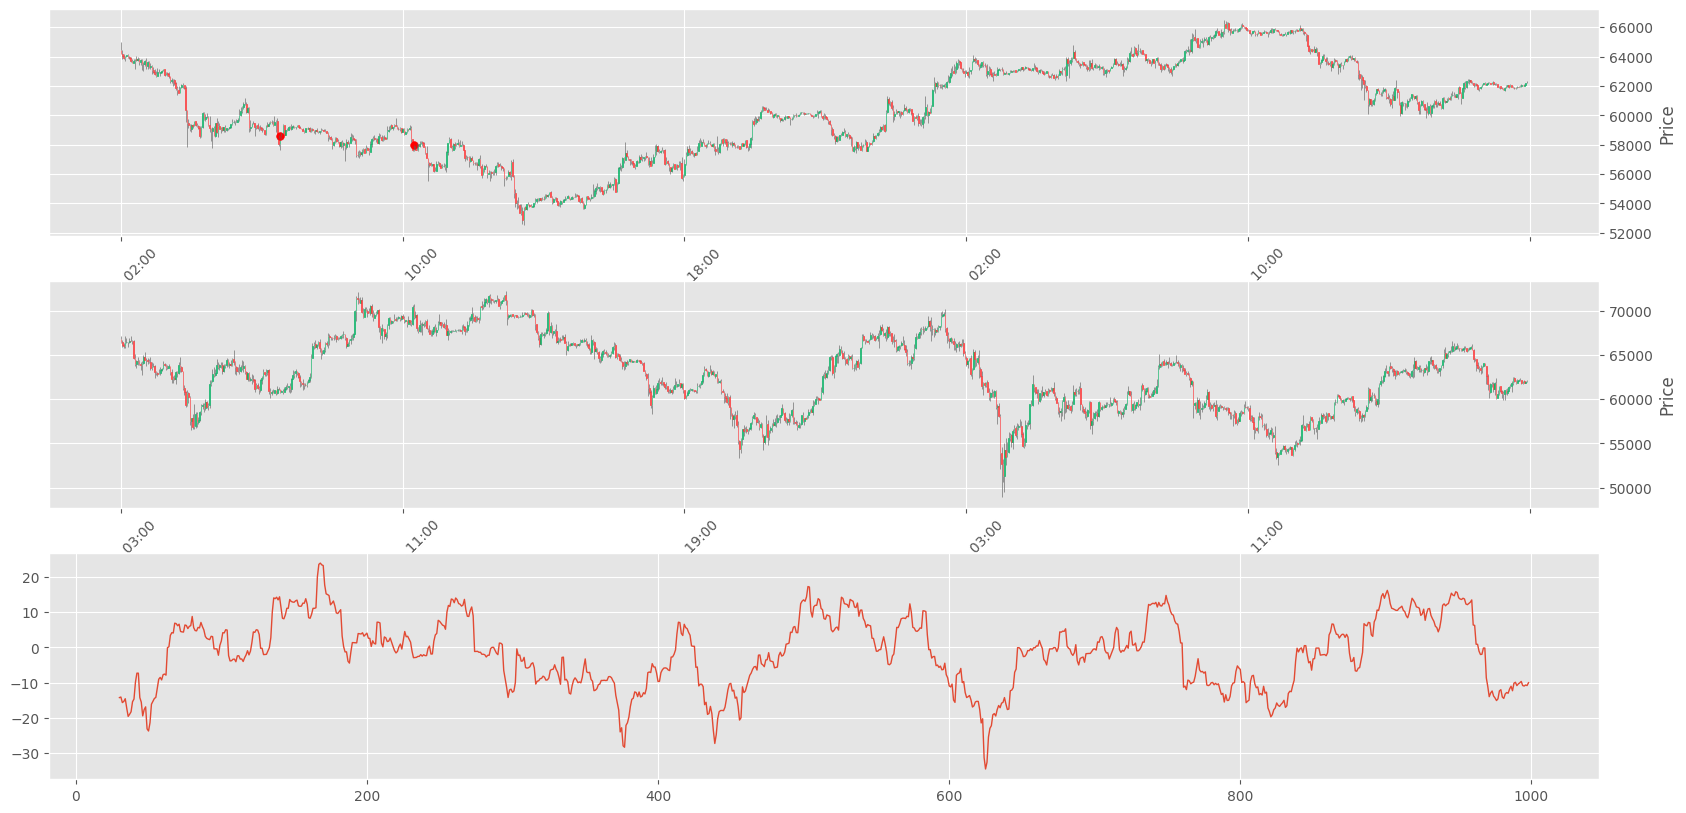

In [36]:
import mplfinance as mpf

ttype = 'sell'
low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# add indicators
indicators = list()
indicator_list = ['Pattern', 'Trend']
configs['Indicator_list'] = indicator_list
for indicator in indicator_list:
    ind_factory = IndicatorFactory.factory(indicator, ttype, configs)
    if ind_factory:
        indicators.append(ind_factory)
        dfs = exchange_api.add_indicator_data(dfs, df, ttype, indicators, ticker, timeframe, data_qty)
        dfs = exchange_api.add_indicator_data(dfs, dfh, ttype, indicators, ticker, '4h', data_qty)

# find signal points
fs = FindSignal(ttype, configs)
fs.patterns = [['Pattern', 'Trend']]
fs.indicator_list = indicator_list
# df = dfs[ticker]['1h']['data'][ttype]
dfs[ticker]['4h'] = dict()
dfs[ticker]['4h']['data'] = dict()
dfs[ticker]['4h']['data'][ttype] = dict()
dfs[ticker]['4h']['data'][ttype] = dfh
data_qty = 1000
data_qty_higher = 1000
points = fs.find_signal(dfs, ticker, '1h', data_qty, data_qty_higher)

# subplots for Pattern and Trend
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

ohlch = dfh.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlch = ohlch.set_index('time')
mpf.plot(ohlch, type='candle', ax=ax2, warn_too_much_data=10000, style='yahoo')

lr_angle = dfh['linear_reg_angle']
ax3.plot(lr_angle, linewidth=1)

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()

for point in points:
    if point[3] == 'buy':
        scatter_candle_points_buy.append((point[2], df.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], df.loc[point[2], 'high']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
plt.show()